# ** Marketing Mix Modeling with LightweightMMM**

## Overview

This notebook serves as a comprehensive demp guide to applying the LightweightMMM package for Marketing Mix Modeling (MMM). Whether you're a marketer, data scientist, or enthusiast, you'll find this resource helpful for understanding and implementing MMM.

### Data Requirements
To use this notebook effectively, your dataset should include columns for time periods (e.g., weeks or months), media spend across various channels, sales data, and any other relevant metrics like campaign or creative details. For data generation guidelines, refer to the official LightweightMMM repository.

### Adaptable Analysis
Throughout this notebook, we provide general code templates and explanations for various MMM analyses. You can adapt these to your specific dataset and marketing questions.


# **0. CONFIGURATION**

This section includes the necessary library installations and imports, setting up the environment for our analysis. It also defines utility functions for visualization and optimization tasks that will be used later in the notebook.


In [1]:
!pip install --upgrade pip
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Cloning https://github.com/google/lightweight_mmm.git to /tmp/pip-req-build-xxgzk2i2
  Running command git clone --filter=blob:none --quiet https://github.com/google/lightweight_mmm.git /tmp/pip-req-build-xxgzk2i2
  Resolved https://github.com/google/lightweight_mmm.git to commit 8ac08a189df55f0e17845a05e3f6dbeb3b13fe20
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.0/285.0 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 20.8 MB/s eta 0:00:00
  Created wheel for lightweight-mmm: filename=lightweight_mmm-0.1.9-py3-none-any.whl size=105259 sha256=d81f3d755cb211b34d257a712ec2113a653cb3e864dd8a7ef6d05c4edcb26609


In [1]:
import pandas as pd
from lightweight_mmm import preprocessing, lightweight_mmm, plot, optimize_media,media_transforms
import jax.numpy as jnp
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import waterfall_chart
import functools
import scipy as sp

In [2]:
def combined_plot(roi_metric, spend_metric, metric_name, channel_names):
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

    sns.barplot(data=roi_metric, ci=None, ax=ax1)
    ax1.set_xticks(range(len(channel_names)))
    ax1.set_xticklabels(channel_names, rotation=45)
    ax1.set_xlabel('Media Channel')
    ax1.set_ylabel('ROI')
    ax1.set_title(f'Estimated {metric_name}')

    ax2 = ax1.twinx()

    ax2.plot(channel_names, spend_metric, color='r', marker='o', label='Spending')
    ax2.set_ylabel('Spending')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()

In [3]:
def optimize_plot(pre_spend,post_spend,media_names):
  fig, ax = plt.subplots()
  plt.title("Pre Post budget allocation")
  spend_media=np.array(list(pre_spend)+list(post_spend)).reshape(2,-1).T
  xlabel=["pre optimization",'post optimization']
  ax.bar([0,1],spend_media[0],label=media_names[0])
  ax.text(0, 0, int(spend_media[0][0]), ha='center', va='bottom', fontsize=10)
  ax.text(1, 0, int(spend_media[0][1]), ha='center', va='bottom', fontsize=10)
  for _ in range(1,len(media_names)):
    bottom=sum(spend_media[:_])
    ax.bar(xlabel,spend_media[_],bottom=bottom,label=media_names[_])
    ax.plot([0.39,0.61],bottom,'r--')
    ax.text(0, bottom[0], int(spend_media[_][0]), ha='center', va='bottom', fontsize=10)
    ax.text(1, bottom[1], int(spend_media[_][1]), ha='center', va='bottom', fontsize=10)
  ax.legend()
  plt.show()

# **1. DATA INPUT**

In this section, we prepare the marketing data for analysis. Notably, we are omitting the variable validation test typically used in marketing mix modeling. This test is crucial for ensuring the quality and suitability of data for modeling purposes.

For more details on variable validation and how to perform these checks, please refer to the [Google Lightweight MMM official repository](https://github.com/google/lightweight_mmm).

This omission is made for the purposes of this demonstration and should be included in a comprehensive analysis.



In [5]:
marketing=pd.read_csv("/content/marketing_data_sample.csv")
marketing.rename(columns={'Week':'TIMEDESC'},inplace=True)
sales=marketing[['TIMEDESC','Sales']].drop_duplicates(['TIMEDESC'])
sales.set_index('TIMEDESC',inplace=True)

date_index=np.unique(marketing["TIMEDESC"])
media_names=np.unique(marketing["Media"])

media_data=pd.DataFrame({i:[marketing[(marketing['TIMEDESC']==j) & (marketing['Media']==i)]['Spend'].sum() for j in date_index] for i in media_names},index=date_index)

## Understanding the Input Data Structure

The dataset used in this notebook encompasses a range of variables that are typical in marketing mix modeling. Below is an overview of the data columns and their respective data types:

```plaintext
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 25 columns):
 #   Column         Dtype  
---  ------         -----  
 0   TIMEDESC       object
 1   Sales          int64  
 2   Period         object
 3   Sold           float64
 4   Price          471 non-null    float64
 5   Vehicle        0 non-null      float64
 6   Media          471 non-null    object
 7   Ad Type        471 non-null    object
 8   Buying Type    471 non-null    object
 9   Data Type      0 non-null      float64
 10  Audience Type  471 non-null    object
 11  Spend          471 non-null    float64
 12  Impression     471 non-null    int64  
 13  Reach          471 non-null    int64  
 14  Frequency      471 non-null    float64
 15  Campaign       471 non-null    object
 16  Funnel         471 non-null    object
 17  Objective      0 non-null      float64
 18  Creative       471 non-null    object
 19  Adset ID       0 non-null      float64
 20  Adset          0 non-null      float64
 21  Ad Format      0 non-null      float64
 22  Category Eval  471 non-null    object
 23  YN Eval        float64
 24  Brand Measure  int64  
```

**Adapting to your dataset**
- **Column Names:** The variables included in this study are indicative. Users should adjust their input data to match these column names or modify the notebook code to align with their dataset's structure.
- **Data Types:** Ensure your data types are consistent with those used here for seamless integration with the analysis code.

**Access to Sample Data**
- **Sample Data Request:** For those interested in the marketing data sample used in this notebook, feel free to contact me through GitHub.
- **Data Generation Guidelines:** Alternatively, for data generation processes and more examples, please refer to the official LightweightMMM repository on GitHub. This resource provides additional guidance on structuring your data for MMM analysis.


In [6]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TIMEDESC       471 non-null    object 
 1   Sales          471 non-null    int64  
 2   Period         471 non-null    object 
 3   Sold           471 non-null    float64
 4   Price          471 non-null    float64
 5   Vehicle        0 non-null      float64
 6   Media          471 non-null    object 
 7   Ad Type        471 non-null    object 
 8   Buying Type    471 non-null    object 
 9   Data Type      0 non-null      float64
 10  Audience Type  471 non-null    object 
 11  Spend          471 non-null    float64
 12  Impression     471 non-null    int64  
 13  Reach          471 non-null    int64  
 14  Frequency      471 non-null    float64
 15  Campaign       471 non-null    object 
 16  Funnel         471 non-null    object 
 17  Objective      0 non-null      float64
 18  Creative  

In [7]:
# Define the point to split the data into training and testing sets
split_point = date_index[-20]

media_data_train = media_data.loc[:split_point]
media_data_test = media_data.loc[split_point:]
target_train = sales.loc[:split_point,'Sales']
target_test = sales.loc[split_point:,'Sales']
costs_train = media_data.loc[:split_point].sum(axis=0).loc[media_data_train.columns]

# Initialize custom scalers for media data, target data, and costs
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

# Scale the training and testing media data, target data, and costs
media_data_train_scaled = media_scaler.fit_transform(media_data_train.values)
target_train_scaled = target_scaler.fit_transform(target_train.values)
costs_scaled = cost_scaler.fit_transform(costs_train.values)
media_data_test_scaled = media_scaler.transform(media_data_test.values)

# **2. MMM Model Pretest**

## Objective

Before diving deep into the MMM analysis, this section is dedicated to conducting a pretest to determine the most suitable model and the optimal degree of seasonality for our dataset.

## Methodology

- **Model Selection**: We evaluate three different adstock models – `adstock`, `hill_adstock`, and `carryover`. Each model offers a unique approach to capturing the delayed and diminishing effects of media spend on sales or other KPIs.
- **Seasonality Testing**: For each model, we experiment with varying degrees of seasonality to understand how seasonal factors impact our KPIs. This helps in capturing periodic patterns that could significantly influence the model's performance.
- **Performance Metrics**: The models are compared based on their Mean Absolute Percentage Error (MAPE) on a test dataset. MAPE is a key metric for assessing the accuracy of predictions, with a lower value indicating a better fit.

## Goal

The primary goal of this pretest is to select the model that minimizes prediction error, providing a robust foundation for the comprehensive MMM analysis. This step ensures that we proceed with the model that best captures the dynamics of our specific dataset.

In [8]:
# A smaller number is used here for a quicker pretest.
# Number of warm-up steps in the MCMC (Markov Chain Monte Carlo) sampling.
number_warmup = 500
# Number of samples to draw from the posterior distribution after warm-up.
number_samples = 500
# Number of independent MCMC chains to run.
number_chains = 3
# Degrees of seasonality in the MMM.
degrees_seasonality = 3

In [9]:
# Define the adstock models and degrees of seasonality to test
adstock_models = ["adstock", "hill_adstock", "carryover"]
degrees_season = [2,3,4]
test_mape = {model: {} for model in adstock_models}
test_pred = {model: {} for model in adstock_models}

# Test each model with different degrees of seasonality and calculate MAPE
for model_name in adstock_models:
    for degrees in degrees_season:
        mmm = lightweight_mmm.LightweightMMM(model_name=model_name)
        mmm.fit(media=media_data_train_scaled, media_prior=costs_scaled, target=target_train_scaled,
                number_warmup=10, number_samples=10, number_chains=1, degrees_seasonality=degrees,
                weekday_seasonality=False, seasonality_frequency=52, seed=1)

        prediction = mmm.predict(media=media_data_test_scaled, target_scaler=target_scaler)
        test_pred[model_name][degrees] = prediction
        p = prediction.mean(axis=0)

        mape = mean_absolute_percentage_error(target_test.values, p)
        test_mape[model_name][degrees] = mape

sample: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s, 5 steps of size 5.80e-04. acc. prob=0.15]   


## Mape comparison

Understanding the MAPE Plot

This plot illustrates the Mean Absolute Percentage Error (MAPE) for three MMM models – `adstock`, `hill_adstock`, and `carryover` – each tested across different degrees of seasonality. MAPE is a crucial metric for assessing prediction accuracy, with lower values indicating more precise models.

Key Observations

- **Hill Adstock Model**: The `hill_adstock` model, particularly with a seasonality degree of 2, demonstrates the lowest MAPE. This suggests it is the most accurate configuration among those tested, making it a strong candidate for our main analysis.
- **Adstock Model**: This model exhibits consistent performance across varying degrees of seasonality, indicating its reliability in capturing media effects without complex seasonal adjustments.
- **Carryover Model**: An interesting observation is the improvement in the `carryover` model's performance with increasing degrees of seasonality, hinting at its potential effectiveness in scenarios with more pronounced seasonal patterns.

Conclusion and Next Steps

Given these insights, the `hill_adstock` model with a seasonality degree of 2 emerges as the optimal choice for detailed analysis due to its superior accuracy as reflected in the MAPE scores. However, to ensure the robustness and applicability of these preliminary findings, further validation and consideration of the specific dataset characteristics are recommended.


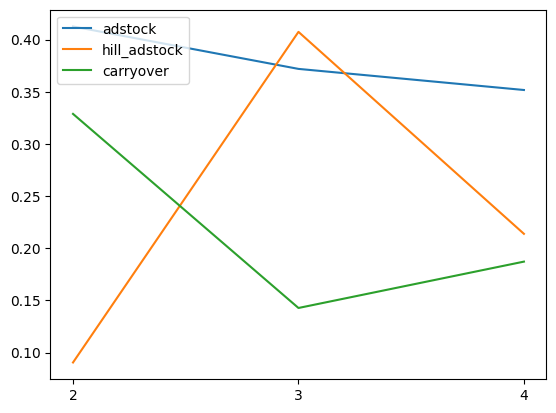

In [10]:
# Plot the MAPE for each model and degree of seasonality
plt.xticks(np.array(degrees_season), np.array(degrees_season))
[plt.plot(test_mape[model].keys(), test_mape[model].values(), label=model) for model in adstock_models]
plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
plt.show()

## Out of sample test

#### Model Prediction Performance

The graphs compare out-of-sample predictions from three models: adstock, hill adstock, and carryover. We assess each model's fit and accuracy using R-squared (R²) and Mean Absolute Percentage Error (MAPE).

- **Adstock Model**: R² of 0.773 and MAPE of 35.166%.
- **Hill Adstock Model**: R² of 0.633 and MAPE of 9.051%.
- **Carryover Model**: R² of 0.762 and MAPE of 14.274%.

While the adstock and carryover models show higher R² values, the hill adstock model has the lowest MAPE, indicating superior predictive accuracy. Consequently, the hill adstock model (seasonality degree=2) is chosen for the main analysis due to its higher accuracy in predictions.


1) adstock model

seasonality degree=4


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


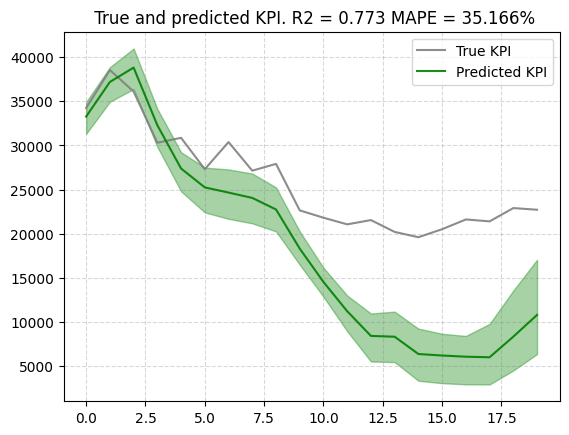

In [11]:
max_degree=min(test_mape['adstock'],key=test_mape['adstock'].get)
print(f'seasonality degree={max_degree}')
plot.plot_out_of_sample_model_fit(test_pred['adstock'][max_degree],target_test.values)

2) hill adstock model

seasonality degree=2


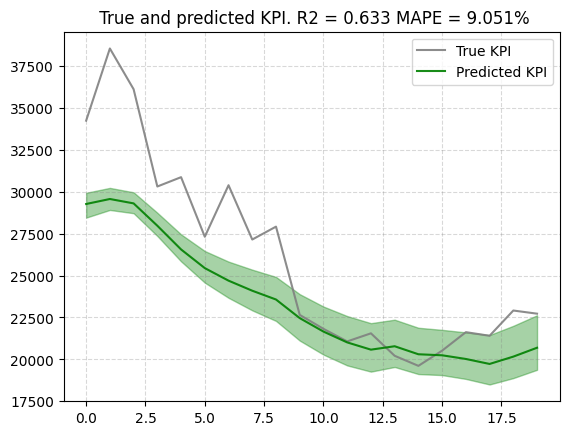

In [12]:
max_degree=min(test_mape['hill_adstock'],key=test_mape['hill_adstock'].get)
print(f'seasonality degree={max_degree}')
plot.plot_out_of_sample_model_fit(test_pred['hill_adstock'][max_degree],target_test.values)

3) carryover model

seasonality degree=3


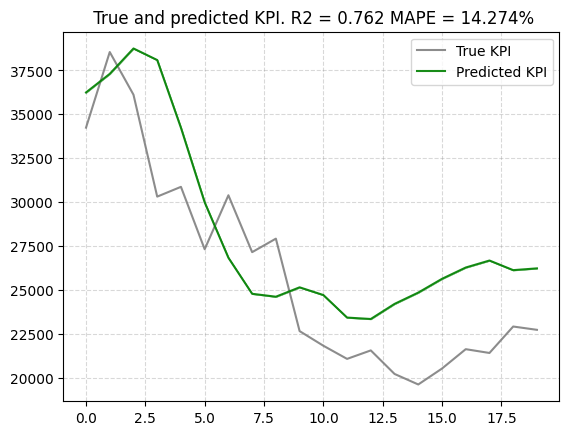

In [13]:
max_degree=min(test_mape['carryover'],key=test_mape['carryover'].get)
print(f'seasonality degree={max_degree}')
plot.plot_out_of_sample_model_fit(test_pred['carryover'][max_degree],target_test.values)

# **3. MMM MODEL FITTING**

In this chapter, we present a set of code templates that demonstrate how to fit various MMM models. These templates are meant for general usage and can be adapted for different MMM scenarios. While we have chosen to proceed with the 'hill_adstock' model with a seasonality of 2 for our specific case, the following sections provide the setup for the 'adstock', 'hill_adstock', and 'carryover' models.

### Workflow Structure for Model Fitting

The structure for setting up and fitting each model is consistent across the following key steps:

1. **Scaling the Data**: Custom scalers are applied to normalize media data, sales data, and costs. This normalization is essential for stabilizing the training process of the models.

2. **Initializing and Fitting the Model**: The `LightweightMMM` package is utilized to initialize and fit the model. This process involves specifying parameters such as the model name, the number of warm-up steps, sample size, and chain count for the MCMC process, as well as the degree of seasonality.

3. **Extracting Model Parameters**: Once the model is fitted, we extract important parameters like media coefficients, exponents, and lag weights, which are pivotal in understanding the model's behavior.

4. **Preparing Data Transformations**: These extracted parameters are used to transform media spend data into adstocked and exponentiated values, reflecting the compounded effect of media spend over time.

5. **Calculating Media Contributions**: Finally, the transformed values are used to calculate the contribution of each media channel to the overall sales, which can be insightful for media planning and strategy.

The code blocks that follow are modular and can be reused or modified for different datasets or MMM requirements. While they are not tailored to any specific analysis or dataset, they serve as a robust starting point for those looking to implement MMM in their projects.



### 1) adstock model
Please, refer to 3) hill adstock model for detailed comments

In [ ]:
# adstock model
costs = media_data.sum(axis=0).loc[media_data.columns]

media_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler2 = preprocessing.CustomScaler(
    divide_operation=jnp.mean)
cost_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_scaled = media_scaler2.fit_transform(media_data.values)
target_scaled = target_scaler2.fit_transform(sales["Sales"].values)
costs_scaled2 = cost_scaler2.fit_transform(costs.values)

mmm = lightweight_mmm.LightweightMMM(model_name="adstock")
mmm.fit(media=media_data_scaled,
        media_prior=costs_scaled2,
        target=target_scaled,
        number_warmup=number_warmup,
        number_samples=number_samples,
        number_chains=number_chains,
        degrees_seasonality=degrees_seasonality,
        weekday_seasonality=False,
        seasonality_frequency=52,
        seed=1)

In [ ]:
coef_media=mmm.trace['coef_media'].mean(axis=0)
exponent=mmm.trace['exponent'].mean(axis=0)
lag_weight=mmm.trace['lag_weight'].mean(axis=0)

coef_trend=mmm.trace['coef_trend'].mean(axis=0)
expo_trend=mmm.trace['expo_trend'].mean(axis=0)
intercept=mmm.trace['intercept'].mean(axis=0)
gamma_seasonality=mmm.trace['gamma_seasonality'].mean(axis=0)

sc=media_scaler2.transform(np.array([1.0]*len(media_names)))

In [ ]:
marketing.loc[:,"Spend_scaled"]=[float(marketing.loc[_,"Spend"]*sc[list(media_names).index(marketing['Media'][_])]) for _ in marketing.index]
marketing['Spend_adstock']=pd.Series()
marketing['Spend_expo_adstock']=pd.Series()
marketing['Contribution']=pd.Series()

for media_name in media_names:
    mask = marketing['Media'] == media_name
    adstock_values = media_transforms.adstock(np.array(marketing.loc[mask, 'Spend_scaled']),lag_weight=np.array(lag_weight[list(media_names).index(media_name)]))
    marketing.loc[mask, 'Spend_adstock'] = adstock_values

for media_name in media_names:
    mask = marketing['Media'] == media_name
    expo_values = media_transforms.apply_exponent_safe(
        np.array(marketing.loc[mask, 'Spend_adstock']),
        exponent=exponent[list(media_names).index(media_name)]
    )
    marketing.loc[mask, 'Spend_expo_adstock'] = expo_values

for media_name in media_names:
    mask = marketing['Media'] == media_name
    marketing.loc[mask, 'Contribution'] = coef_media[list(media_names).index(media_name)]*marketing.loc[mask, 'Spend_expo_adstock']/float(target_scaler2.transform(np.array([1])))

media_baseline_contribution=plot.create_media_baseline_contribution_df(mmm,target_scaler2)

### 2) carryover model
Please, refer to 3) hill adstock model for detailed comments

In [ ]:
# carryover model
costs = media_data.sum(axis=0).loc[media_data.columns]

media_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler2 = preprocessing.CustomScaler(
    divide_operation=jnp.mean)
cost_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_scaled = media_scaler2.fit_transform(media_data.values)
target_scaled = target_scaler2.fit_transform(sales["Sales"].values)
costs_scaled2 = cost_scaler2.fit_transform(costs.values)

mmm = lightweight_mmm.LightweightMMM(model_name="carryover")
mmm.fit(media=media_data_scaled,
        media_prior=costs_scaled2,
        target=target_scaled,
        number_warmup=100,
        number_samples=100,
        number_chains=2,
        degrees_seasonality=2,
        weekday_seasonality=False,
        seasonality_frequency=52,
        seed=1)

In [ ]:
coef_media=mmm.trace['coef_media'].mean(axis=0)
exponent=mmm.trace['exponent'].mean(axis=0)
ad_effect_retention_rate=mmm.trace['ad_effect_retention_rate'].mean(axis=0)
peak_effect_delay=mmm.trace['peak_effect_delay'].mean(axis=0)

coef_trend=mmm.trace['coef_trend'].mean(axis=0)
expo_trend=mmm.trace['expo_trend'].mean(axis=0)
intercept=mmm.trace['intercept'].mean(axis=0)
gamma_seasonality=mmm.trace['gamma_seasonality'].mean(axis=0)

sc=media_scaler2.transform(np.array([1.0]*len(media_names)))

In [ ]:
marketing.loc[:,"Spend_scaled"]=[float(marketing.loc[_,"Spend"]*sc[list(media_names).index(marketing['Media'][_])]) for _ in marketing.index]
marketing['Spend_carryover']=pd.Series()
marketing['Spend_expo_carryover']=pd.Series()
marketing['Contribution']=pd.Series()

for media_name in media_names:
    mask = marketing['Media'] == media_name
    adstock_values = media_transforms.carryover(
        np.array(marketing.loc[mask, 'Spend_scaled']).reshape(-1,1),
        ad_effect_retention_rate=np.array(ad_effect_retention_rate[list(media_names).index(media_name)]),
        peak_effect_delay=np.array(peak_effect_delay[list(media_names).index(media_name)]))
    marketing.loc[mask, 'Spend_carryover'] = adstock_values

for media_name in media_names:
    mask = marketing['Media'] == media_name
    expo_values = media_transforms.apply_exponent_safe(
        np.array(marketing.loc[mask, 'Spend_carryover']),
        exponent=exponent[list(media_names).index(media_name)]
    )
    marketing.loc[mask, 'Spend_expo_carryover'] = expo_values

for media_name in media_names:
    mask = marketing['Media'] == media_name
    marketing.loc[mask, 'Contribution'] = coef_media[list(media_names).index(media_name)]*marketing.loc[mask, 'Spend_expo_carryover']/float(target_scaler2.transform(np.array([1])))

media_baseline_contribution=plot.create_media_baseline_contribution_df(mmm,target_scaler2)

### 3) hill adstock model

In [14]:
# Sum the costs across all media channels for the entire dataset
costs = media_data.sum(axis=0).loc[media_data.columns]

# Initialize custom scalers for media data, target data, and costs
# The scalers normalize data by dividing by the mean, which helps in stabilizing the training process
media_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)

# Scale the media data, target (sales) data, and costs
media_data_scaled = media_scaler2.fit_transform(media_data.values)
target_scaled = target_scaler2.fit_transform(sales["Sales"].values)
costs_scaled2 = cost_scaler2.fit_transform(costs.values)

# Instantiate the LightweightMMM model with the 'hill_adstock' model specification
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")

# Fit the model to the scaled media data, media prior (scaled costs), and target (scaled sales)
# The model is configured to use the parameters determined from the pretest,
# including the degrees of seasonality, number of warmup steps, samples, and chains
mmm.fit(media=media_data_scaled,
        media_prior=costs_scaled2,
        target=target_scaled,
        number_warmup=1000,  # Number of steps for the "burn-in" period
        number_samples=1000,  # Number of posterior samples to draw
        number_chains=4,      # Number of chains for MCMC to improve convergence
        degrees_seasonality=2,  # Optimal degree of seasonality based on pretest
        weekday_seasonality=False,  # No separate seasonality for weekdays
        seasonality_frequency=52,   # Assuming weekly data for a year
        seed=1)                     # Seed for random number generator for reproducibility


/usr/local/lib/python3.10/dist-packages/lightweight_mmm/lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:54<00:00, 36.56it/s, 511 steps of size 9.34e-03. acc. prob=0.95]


In [15]:
# Extract mmm parameter results accroding to the model selection
coef_media = mmm.trace['coef_media'].mean(axis=0)
half_max_effective_concentration = mmm.trace['half_max_effective_concentration'].mean(axis=0)
lag_weight = mmm.trace['lag_weight'].mean(axis=0)
slope = mmm.trace['slope'].mean(axis=0)
coef_trend = mmm.trace['coef_trend'].mean(axis=0)
expo_trend = mmm.trace['expo_trend'].mean(axis=0)
intercept = mmm.trace['intercept'].mean(axis=0)
gamma_seasonality = mmm.trace['gamma_seasonality'].mean(axis=0)
sc = media_scaler2.transform(np.array([1.0] * len(media_names)))

In [16]:
# Compile regression results into dataframe for further analysis
marketing.loc[:, "Spend_scaled"] = [
    float(marketing.loc[_, "Spend"] * sc[list(media_names).index(marketing['Media'][_])])
    for _ in marketing.index
]

marketing['Spend_adstock'] = pd.Series(dtype=float)
marketing['Spend_hill_adstock'] = pd.Series(dtype=float)
marketing['Contribution'] = pd.Series(dtype=float)

for media_name in media_names:
    mask = marketing['Media'] == media_name
    adstock_values = media_transforms.adstock(
        np.array(marketing.loc[mask, 'Spend_scaled']),
        lag_weight=np.array(lag_weight[list(media_names).index(media_name)])
    )
    marketing.loc[mask, 'Spend_adstock'] = adstock_values

for media_name in media_names:
    mask = marketing['Media'] == media_name
    hill_values = media_transforms.hill(
        np.array(marketing.loc[mask, 'Spend_adstock']),
        half_max_effective_concentration=half_max_effective_concentration[list(media_names).index(media_name)],
        slope=slope[list(media_names).index(media_name)]
    )
    marketing.loc[mask, 'Spend_hill_adstock'] = hill_values


for media_name in media_names:
    mask = marketing['Media'] == media_name
    marketing.loc[mask, 'Contribution'] = (
        coef_media[list(media_names).index(media_name)] *
        marketing.loc[mask, 'Spend_hill_adstock'] /
        float(target_scaler2.transform(np.array([1])))
    )

media_baseline_contribution = plot.create_media_baseline_contribution_df(mmm, target_scaler2)
media_baseline_contribution.set_index(date_index, inplace=True)

<ipython-input-16-5aaa1c6cf1cb>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  float(target_scaler2.transform(np.array([1])))


# **4. MODEL DIAGNOSTICS**

After fitting our chosen Hill Adstock model, it is essential to evaluate its performance and the reliability of its estimates. This section provides a comprehensive overview of the model's outputs, including summary statistics and visual diagnostics.

## Overview of Diagnostics

1. **Model Summary**: We begin with a summary of the model's parameters, which includes mean values and standard deviations. This gives us an insight into the estimated effect sizes and uncertainties associated with each parameter in the model.

2. **Model Fit Visualization**: Next, we assess the model's predictive accuracy by comparing the predicted KPIs against the actual data. A plot of model fit will help us visualize how well the model captures the observed data trends over time.

3. **Media Channel Posterior Distributions**: Lastly, we examine the posterior distributions of the media channel effects. This step is crucial as it helps us understand the distribution and certainty of our estimates for the media contributions to the KPIs.

The outputs from this section will guide us in validating the model's assumptions and ensuring that it has captured the underlying patterns in the data effectively.

In [17]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
                      coef_media[0]      1.17      0.38      1.12      0.58      1.73   1968.64      1.00
                      coef_media[1]      1.09      0.43      1.03      0.41      1.72   2023.44      1.00
                      coef_media[2]      0.34      0.29      0.26      0.00      0.73   1940.78      1.00
                      coef_trend[0]      0.00      0.00      0.00     -0.00      0.01   1548.99      1.00
                         expo_trend      0.67      0.15      0.63      0.50      0.90   1729.42      1.00
             gamma_seasonality[0,0]      0.01      0.01      0.01     -0.01      0.02   3401.77      1.00
             gamma_seasonality[0,1]     -0.01      0.01     -0.01     -0.02      0.01   2134.39      1.00
             gamma_seasonality[1,0]      0.00      0.01      0.00     -0.01      0.02   3670.86      1.00
             gamma_seasonality[1,1]     -0.01

### Model Summary Interpretation

The model summary indicates satisfactory convergence with `r_hat` values close to 1. However, 77 divergences suggest potential model fit issues. Further scrutiny of model specifications and priors may be necessary to address these divergences. The `coef_media` estimates reveal positive effects of media channels on the target, yet caution is advised due to the noted sampling challenges.


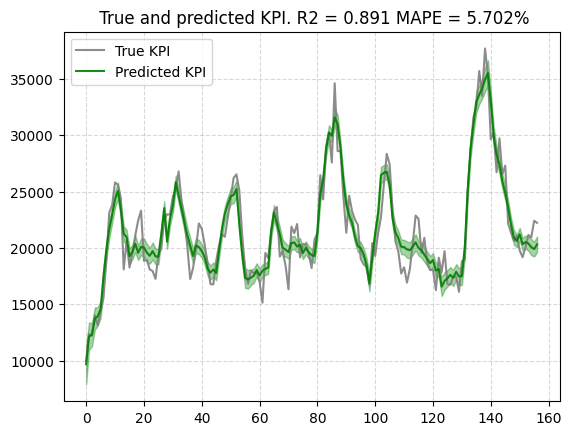

In [18]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

### Model Fit Evaluation

The model fit plot reveals a high R² of 0.891, indicating that the model explains a large proportion of the variance in the KPIs. The MAPE has improved to 5.702%, reflecting a high predictive accuracy. While the MAPE is an important metric for evaluating model performance, the true test of the model lies in its ability to recover the underlying reality reflected in the parameters. A thorough examination of the parameter estimates is essential to ensure they align with known effects and business understanding. This ensures the model's utility in strategic decision-making is grounded in reality.


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:957: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "histogram" failed type inference due to: No implementation of function Function(<function histogram at 0x79ae59d4bbe0>) found for signature:
 
 >>> histogram(readonly buffer(float32, 1d, C), bins=int64, range=UniTuple(readonly buffer(float32, 0d, C) x 2))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in fu

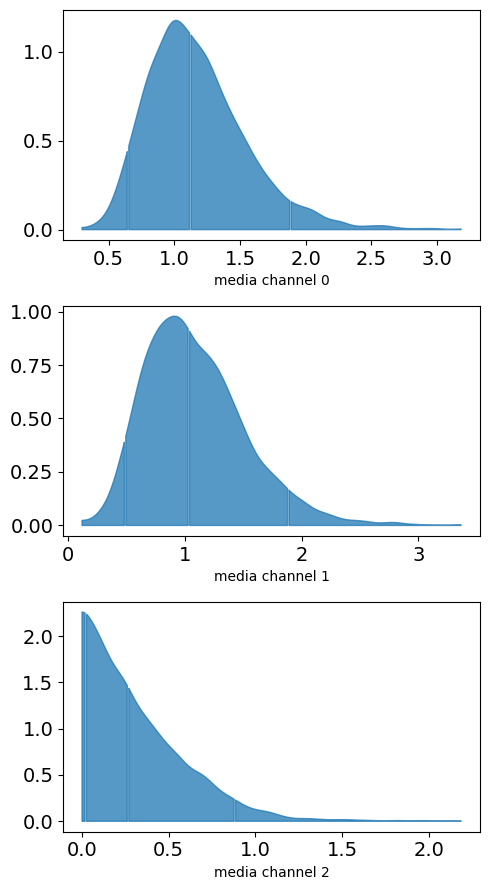

In [19]:
plot.plot_media_channel_posteriors(media_mix_model=mmm)

### Posterior Distributions of Media Channel Effects

The plots above depict the posterior distributions for the coefficients of three media channels. These distributions are derived from the model's outputs and give us a probabilistic understanding of the effects of each media channel:

- **Media Channel 0**: The distribution is centered around a mean greater than 1, indicating a strong positive effect on the KPI. The distribution is fairly narrow, suggesting a high level of certainty in this estimate.
- **Media Channel 1**: This channel's effect also centers above 1 but with a wider distribution, implying a positive effect with more uncertainty.
- **Media Channel 2**: The effect is positive but appears to be smaller in magnitude compared to the others, and the distribution is skewed, suggesting some uncertainty and potential non-linearity in its impact on the KPI.

These distributions allow us to visually assess the certainty of our model regarding the impact of each media channel. A narrower peak indicates more confidence in the effect size, while a wider distribution suggests more variability and less certainty. It is crucial for media planners to understand these uncertainties to make informed decisions about budget allocations to various channels.


# **5.INSIGHTS & REPORTS**


### Seasonality and Trend Insights

#### Overview

This section examines the recurring patterns and long-term trajectories in our KPIs, captured by the model as seasonality and trend. Understanding these elements helps in identifying the optimal timing for media spending and recognizing broader market movements.

- **Seasonality** reflects periodic fluctuations, which can inform the timing of marketing campaigns.
- **Trend** indicates the general direction of KPIs over time, often linked to brand and market dynamics.

We compare a computed seasonality-trend line (`ST`) against the model's baseline to visualize these patterns. The focus here is to grasp the time-related influences within the data, rather than to evaluate the model's predictive precision.

In [20]:
linear_t= np.arange(len(date_index))
seasonality=media_transforms.calculate_seasonality(number_periods=len(date_index), degrees=len(gamma_seasonality), gamma_seasonality=gamma_seasonality)/float(target_scaler2.transform(np.array([1])))
trend=(coef_trend*(linear_t**expo_trend)+intercept)/float(target_scaler2.transform(np.array([1])))

ST=seasonality+trend

<ipython-input-20-e6e99369bb81>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  seasonality=media_transforms.calculate_seasonality(number_periods=len(date_index), degrees=len(gamma_seasonality), gamma_seasonality=gamma_seasonality)/float(target_scaler2.transform(np.array([1])))
<ipython-input-20-e6e99369bb81>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  trend=(coef_trend*(linear_t**expo_trend)+intercept)/float(target_scaler2.transform(np.array([1])))


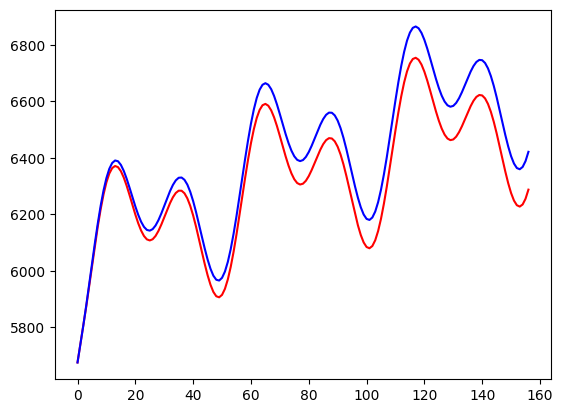

In [21]:
# gap between trend value by "plot.create_media_baseline_contribution_df" and calculation above
plt.plot(linear_t,media_baseline_contribution["baseline contribution"],c='red')
plt.plot(linear_t,ST,c='blue')
plt.show()

### Time Series Decomposition

#### Visualizing Trend and Seasonality

Time series decomposition allows us to dissect the observed data into its core components:

- **Trend**: Showcases the long-term progression of the data, highlighting any persistent upward or downward movement over time.
- **Seasonality**: Captures regular patterns that repeat over a known period, such as daily, weekly, or seasonal fluctuations.

The plots separately illustrate the isolated trend and seasonal components extracted from the KPIs, as well as their combined effect. This decomposition is crucial for understanding the distinct factors that drive variations in the time series data.

By analyzing these components, we can make more informed decisions on adjusting marketing strategies according to seasonal demands or aligning with long-term trends.


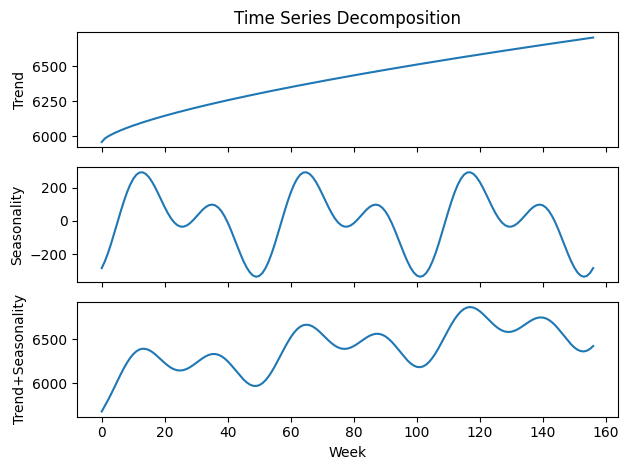

In [22]:
ax1 = plt.subplot(3, 1, 1)
plt.title('Time Series Decomposition')
plt.plot(linear_t,trend)
plt.ylabel('Trend')
plt.xticks(visible=False)

ax2 = plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(linear_t,seasonality)
plt.ylabel('Seasonality')
plt.xticks(visible=False)

ax3 = plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(linear_t,ST)
plt.ylabel('Trend+Seasonality')
plt.xlabel('Week')

plt.tight_layout()
plt.show()

### YoY Sales Decomposition

#### Unveiling Sales Changes Between Years

This section focuses on decomposing the changes in sales from one year to another, breaking down the total difference into contributions from the baseline and media spend. By comparing periods from 2018 and 2019, we gain insights into underlying drivers of sales performance.

- **Baseline Contribution**: Reflects sales changes attributed to factors other than media, such as brand equity or market trends.
- **Media Contribution**: Represents the incremental sales driven by media spending.

The bar chart visualization will show the total sales for 2018, the changes in the baseline, the additional sales attributed to media, and the resulting total sales for 2019. This decomposition is key to understanding the impact of strategic decisions and market conditions on sales outcomes.



In [23]:
comparing_period1=[_ for _ in date_index if _[:4]=='2018']
comparing_period2=[_ for _ in date_index if _[:4]=='2019']

total_sales1=sales.loc[comparing_period1,'Sales'].sum()
total_sales2=sales.loc[comparing_period2,'Sales'].sum()

delta_baseline=\
media_baseline_contribution.loc[comparing_period2,"baseline contribution"].sum()-media_baseline_contribution.loc[comparing_period1,"baseline contribution"].sum()

delta_media=total_sales2-total_sales1-delta_baseline

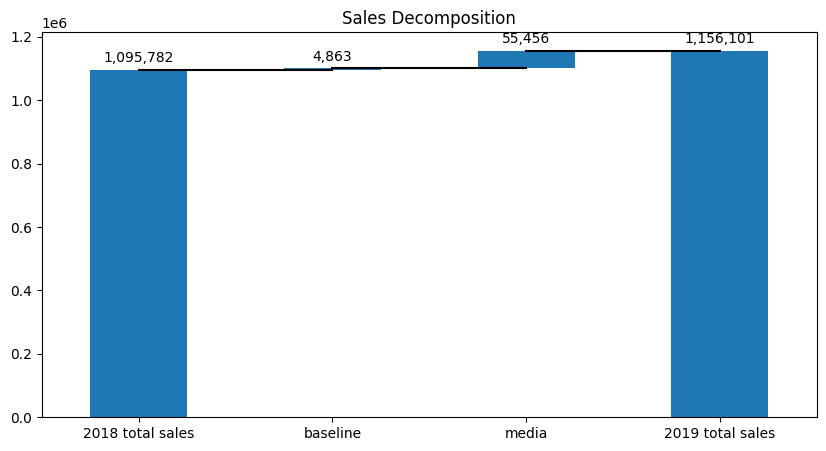

In [24]:
index = ['2018 total sales','baseline','media']
data = {'amount': [total_sales1,delta_baseline,delta_media]}

trans = pd.DataFrame(data=data,index=index)
blank = trans.amount.cumsum().shift(1).fillna(0)

total = trans.sum().amount
trans.loc["2019 total sales"]= total
blank.loc["2019 total sales"] = total

step = blank.reset_index(drop=True).repeat(3).shift(-1)
step[1::3] = np.nan

blank.loc["2019 total sales"] = 0

my_plot = trans.plot(kind='bar', stacked=True, bottom=blank,legend=None, figsize=(10, 5), title="Sales Decomposition")
my_plot.plot(step.index, step.values,'k')

y_height = trans.amount.cumsum().shift(1).fillna(0)

max = trans.max()
neg_offset = max / 25
pos_offset = max / 50
plot_offset = int(max / 15)

loop = 0
for index, row in trans.iterrows():
    if row['amount'] == total:
        y = y_height[loop]
    else:
        y = y_height[loop] + row['amount']
    if row['amount'] > 0:
        y += pos_offset
    else:
        y -= neg_offset
    my_plot.annotate("{:,.0f}".format(row['amount']),(loop,y),ha="center")
    loop+=1

my_plot.set_xticklabels(trans.index,rotation=0)
plt.show()

### Media Insight# Media Insights

#### Quantifying Media Impact and ROI

This section focuses on extracting actionable insights from the model regarding the impact of different media channels on sales and their respective ROI. We utilize the `get_posterior_metrics` function to retrieve the posterior distributions of media contributions and ROI, and then visualize these metrics to better understand the effectiveness of each media type.

- **Media Contribution**: We assess the percentage contribution of each media channel to total sales, which helps in identifying which channels are driving performance.
- **ROI**: We calculate the ROI for each media channel, providing a measure of the efficiency of media spend.

Visualizations created here will include an area plot showing the cumulative contribution of media over time and bar charts representing the contribution and ROI for each media channel.

In [25]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler2, cost_scaler=cost_scaler2)

Media Decomposition

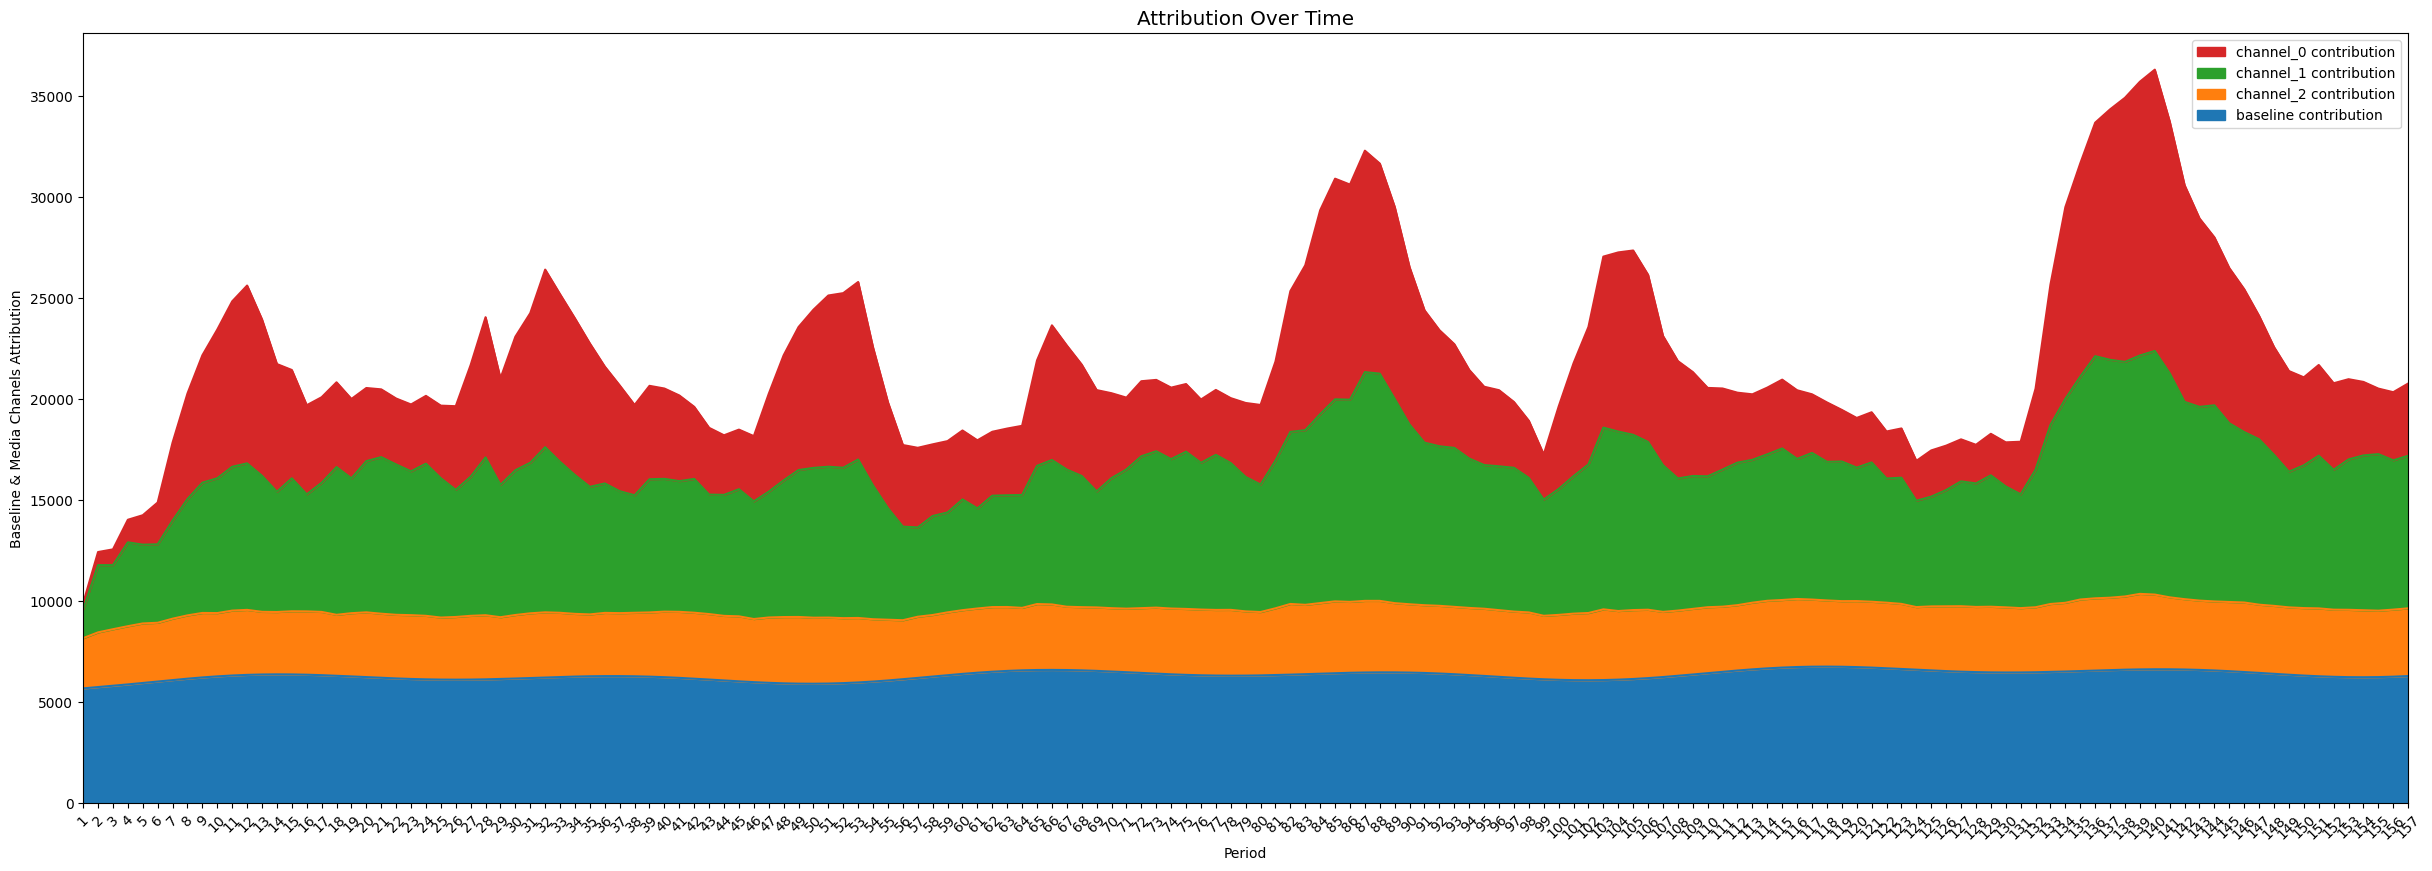

In [26]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler2,
                                                fig_size=(30,10))

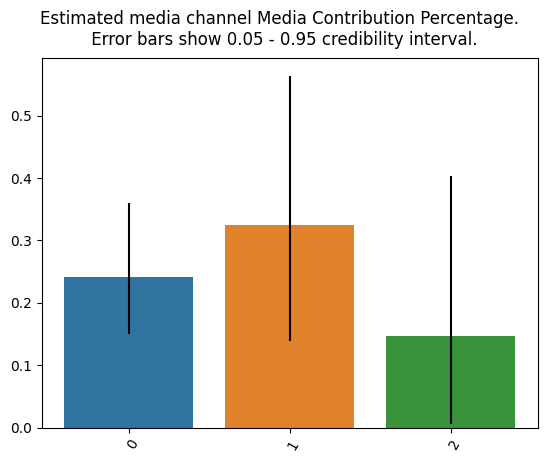

In [27]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")

Media ROI & spend

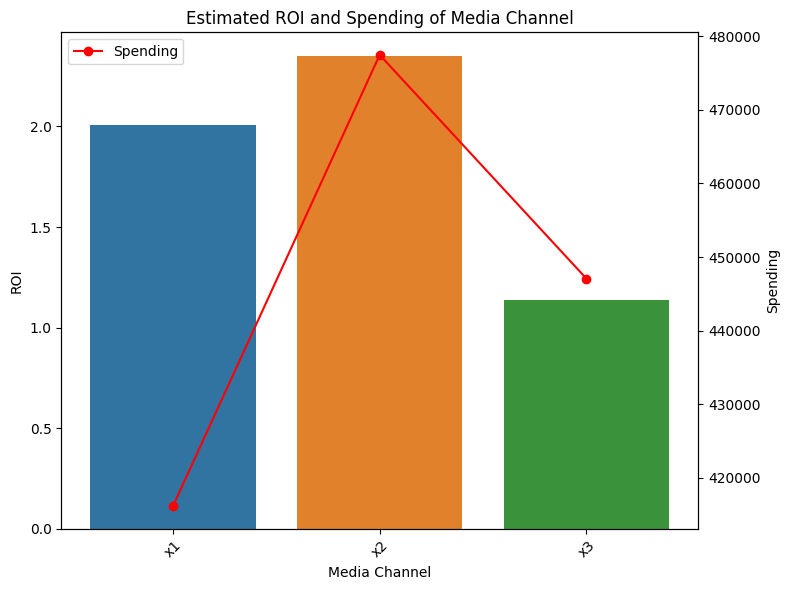

In [28]:
combined_plot(roi_hat, costs, 'ROI and Spending of Media Channel', media_names)

Media ROAS & spend

In [29]:
# for certain period
target_period=date_index[30:80]

ROAS=[]
spending=[]

for _ in media_names:
  zero_spend=media_data.copy()
  zero_spend.loc[target_period,_]=0; zero_spend_scaled=media_scaler2.transform(zero_spend.values)
  delta=mmm.predict(media=media_data_scaled,target_scaler=target_scaler2)-mmm.predict(media=zero_spend_scaled,target_scaler=target_scaler2)
  m=[delta[_][list(date_index).index(target_period[0]):list(date_index).index(target_period[-1])].sum() for _ in range(len(delta))]
  s=media_data[_][list(date_index).index(target_period[0]):list(date_index).index(target_period[-1])].sum()
  ROAS.append(m/(s))
  spending.append(s)

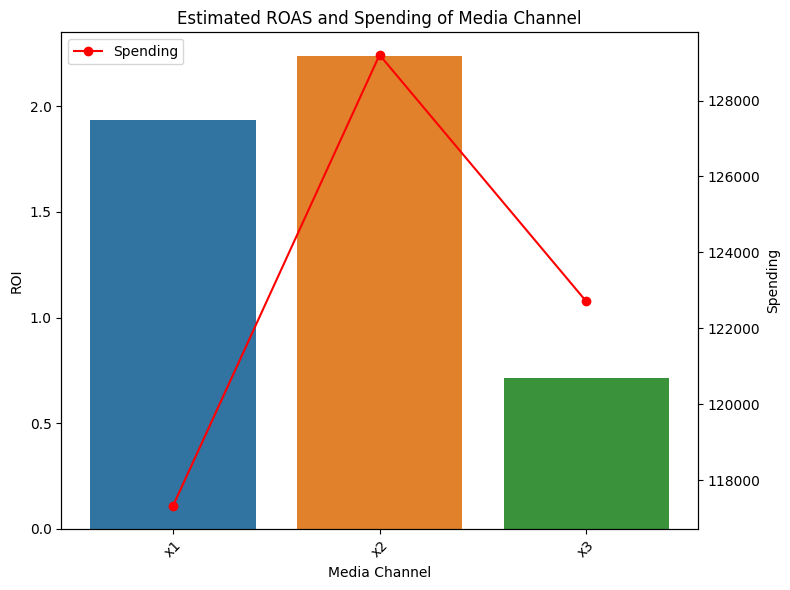

In [30]:
combined_plot(ROAS, spending, 'ROAS and Spending of Media Channel', media_names)

### Media ROAS and mROAS

#### Calculating Efficiency Metrics

In this section, we calculate two crucial efficiency metrics for media spending: ROAS and mROAS. These metrics are different from ROI as used in MMM:

- **ROAS (Return on Advertising Spend)** measures the gross revenue generated for every dollar spent on advertising. It does not account for the cost of goods sold or other expenses.
- **mROAS (Marginal ROAS)** assesses the additional return generated by a marginal increase in advertising spend. It's a measure of the efficiency of incremental investment.

Both ROAS and mROAS provide a more granular view of media spending efficiency, complementing the ROI insights provided by the MMM.

In [31]:
# for certain period
target_period=date_index[30:80]

mROAS=[]
margin=[];spending=[]

for _ in media_names:
  increased_spend=media_data.copy()
  increased_spend.loc[target_period,_]=media_data[_].loc[target_period]*1.01; increased_spend_scaled=media_scaler2.transform(increased_spend.values)
  delta=mmm.predict(media=increased_spend_scaled,target_scaler=target_scaler2)-mmm.predict(media=media_data_scaled,target_scaler=target_scaler2)
  m=[delta[_][list(date_index).index(target_period[0]):list(date_index).index(target_period[-1])].sum() for _ in range(len(delta))]
  s=media_data[_][list(date_index).index(target_period[0]):list(date_index).index(target_period[-1])].sum()
  mROAS.append(m/(0.01*s))
  margin.append(m);spending.append(s)

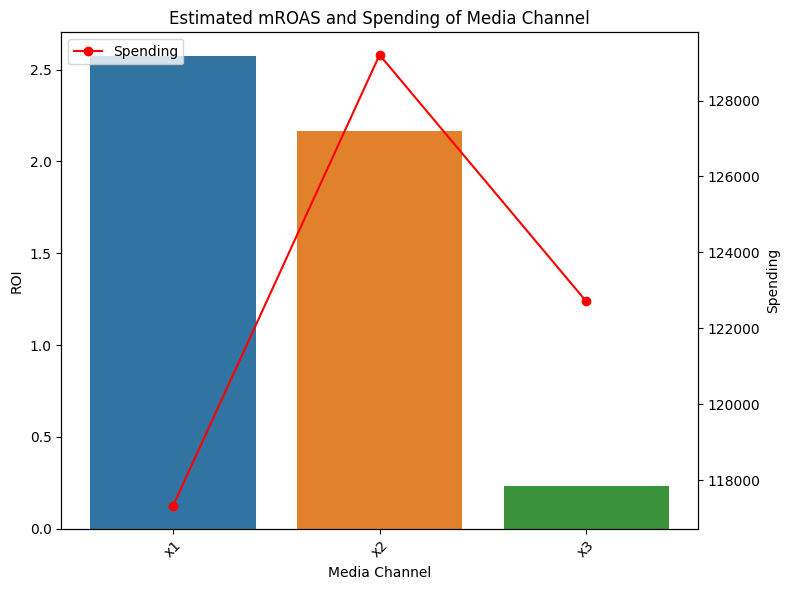

In [32]:
combined_plot(mROAS, spending, 'mROAS and Spending of Media Channel', media_names)

### Media Spend Response Curves

#### Evaluating the Impact of Media Investments

This section is dedicated to analyzing the response curves that illustrate the relationship between media spend and the performance KPIs. Response curves are crucial to understanding the effectiveness of media investment and to identify the point of diminishing returns.

- **Response Curves**: These curves visualize the incremental impact on the KPI as media spend increases. They allow us to see how effectively each additional dollar contributes to the target metric, such as sales or conversions.

By plotting these response curves, we can assess the efficiency of media spending across different channels and optimize the allocation of the budget to maximize the KPI.

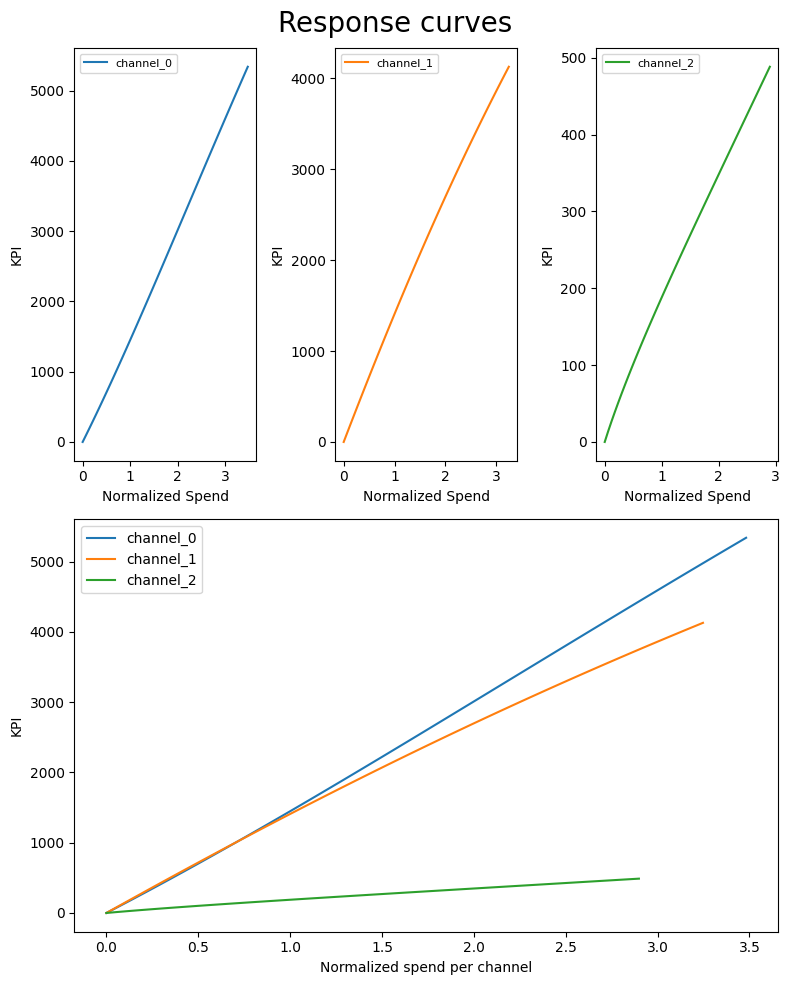

In [33]:
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler2, seed=1)

### Campaign Performance Insights

#### Analyzing Campaign Effectiveness

In this section, we turn our focus to evaluating the effectiveness of various marketing campaigns. By analyzing spend and contribution data, we can gain insights into which campaigns are driving sales and yielding a high return on investment.

- **Campaign Spend and Contribution**: We assess how much each campaign contributes to sales relative to its spend. This analysis helps in identifying the most effective campaigns.
- **Baseline Sales**: The baseline contribution, which is sales not attributed to any campaign, is included for comparison.
- **ROI Calculation**: We compute the return on investment for each campaign over a specific period, giving us a clearer picture of campaign efficiency.

The stack plot visualization will display the attribution over time for each campaign, along with the baseline, allowing us to see the dynamic interplay between campaign-driven sales and the underlying sales trend.

In [34]:
campaign_names=np.unique(marketing['Campaign'])

campaign_spend=pd.DataFrame({i:[marketing[(marketing['TIMEDESC']==j) & (marketing['Campaign']==i)]['Spend_scaled'].sum() for j in date_index] for i in campaign_names},index=date_index)
campaign_contribution=pd.DataFrame({i:[marketing[(marketing['TIMEDESC']==j) & (marketing['Campaign']==i)]['Contribution'].sum() for j in date_index] for i in campaign_names},index=date_index)
baseline=media_baseline_contribution['baseline contribution']
baseline.index=date_index
campaign_contribution['Baseline']=baseline
campaign_contribution=campaign_contribution[['Baseline']+list(campaign_names)]

Campaign Decomposition

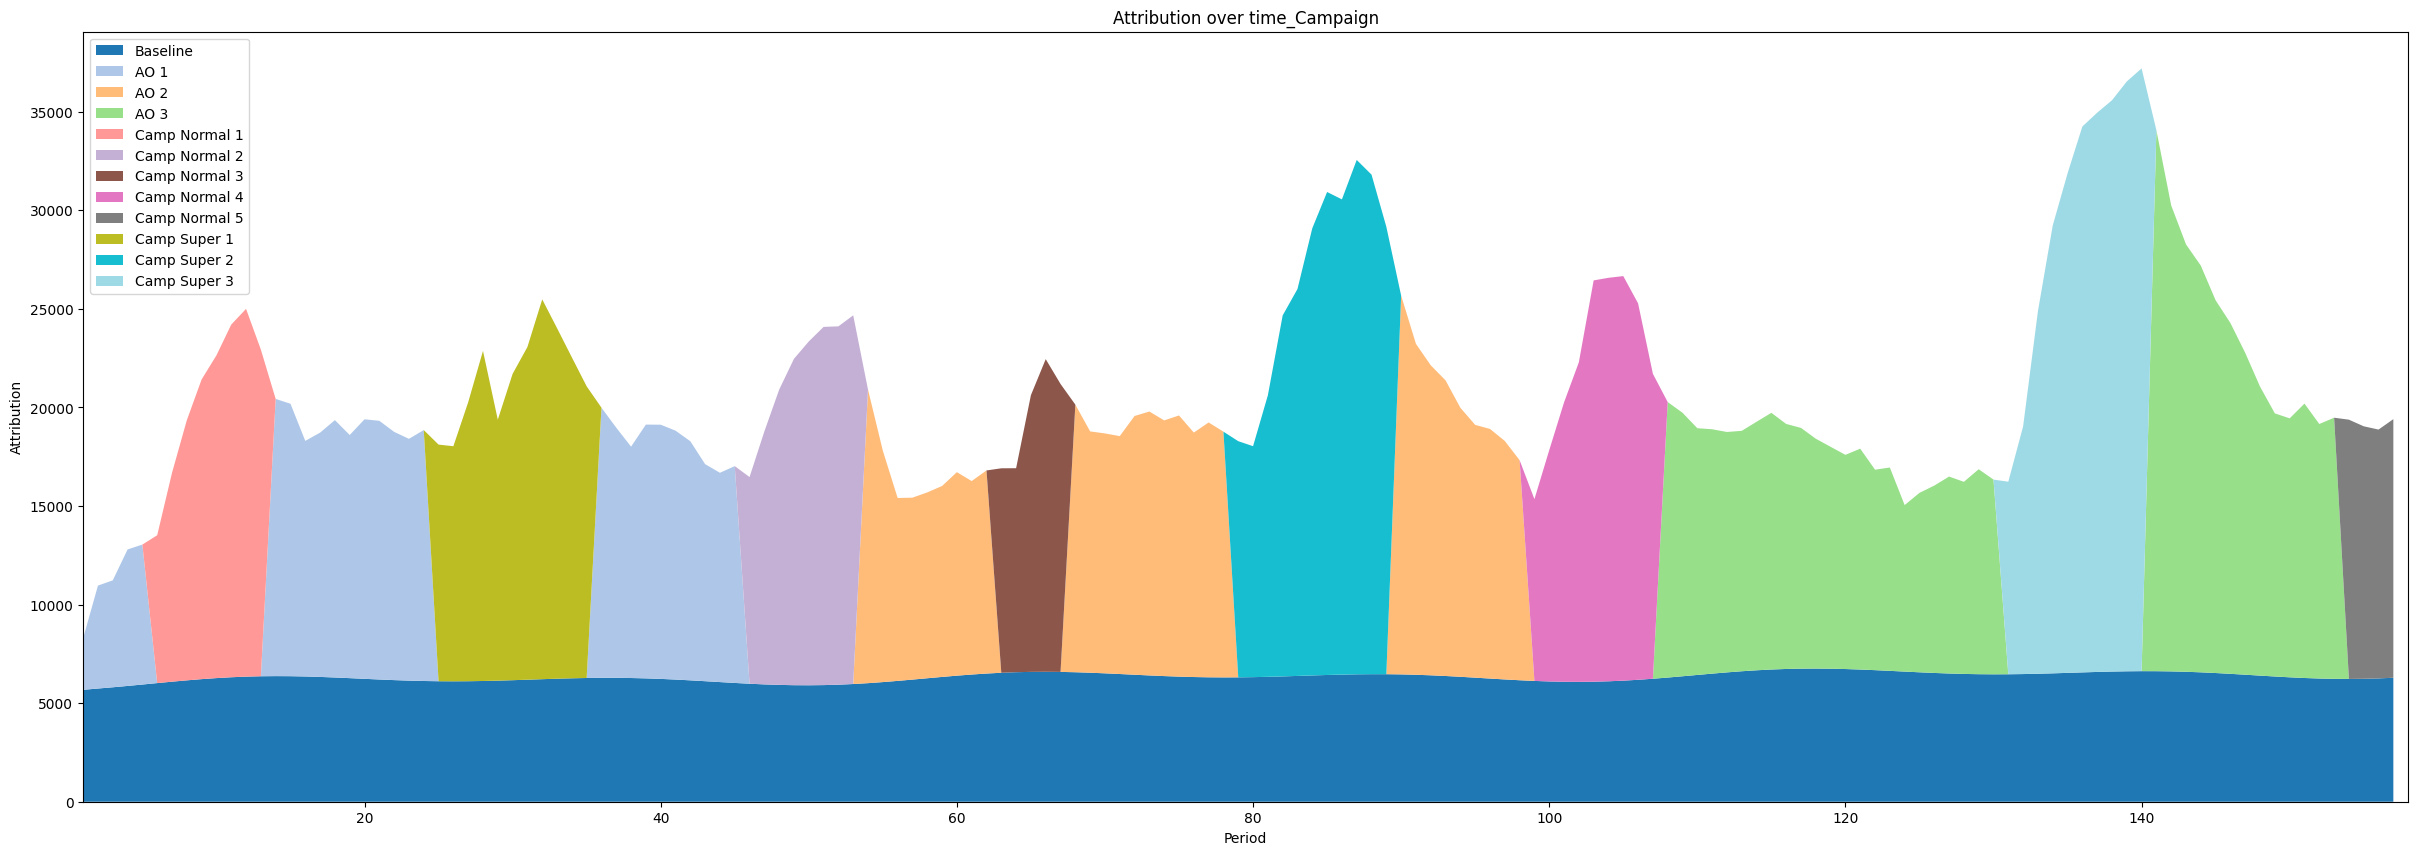

In [35]:
colormap = cm.get_cmap('tab20', len(campaign_contribution.columns))
plt.figure(figsize=(30, 10))
plt.stackplot(np.arange(1,len(campaign_contribution.index)+1), campaign_contribution.values.T, labels=campaign_contribution.columns, colors=colormap.colors)
plt.xlim(1, len(campaign_contribution.index)+1)
plt.legend(loc='upper left',bbox_to_anchor=(0, 1))
plt.title('Attribution over time_Campaign')
plt.xlabel('Period')
plt.ylabel('Attribution')
plt.show()

Campaign ROI & spend

In [36]:
# specific period insight
target_period=date_index[-30:]
valid_campaign=[_ for _ in campaign_names if (campaign_spend.loc[target_period].sum()>0)[_]]

In [37]:
campaign_roi=campaign_contribution[valid_campaign].loc[target_period]/campaign_spend[valid_campaign].loc[target_period]
campaign_roi_mean=campaign_contribution[valid_campaign].loc[target_period].sum()/campaign_spend[valid_campaign].loc[target_period].sum()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


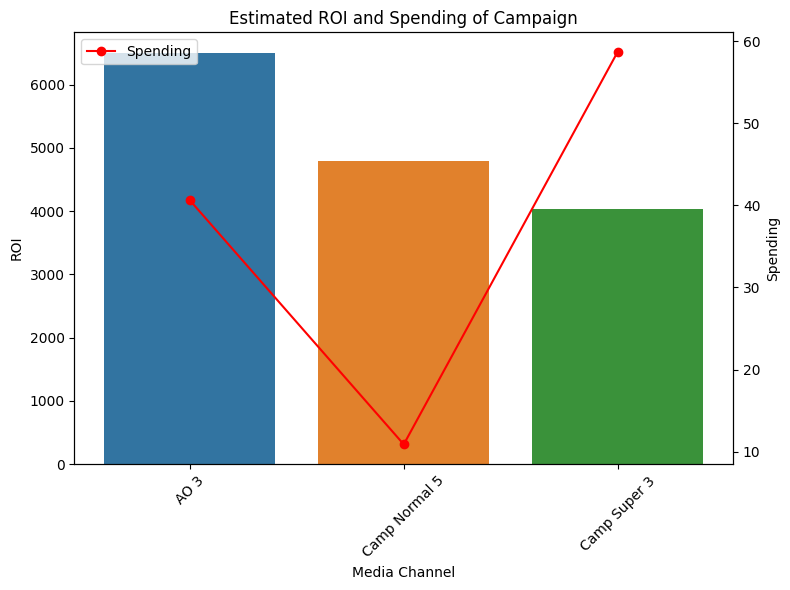

In [38]:
combined_plot(campaign_roi, campaign_spend.loc[target_period,valid_campaign].sum(), 'ROI and Spending of Campaign', valid_campaign)

### Creative ROI Analysis

#### Assessing Creative Performance within a Campaign

This section evaluates the efficiency of individual creatives within a selected campaign, "Camp Normal 2." By comparing the spend against the contribution each creative makes, we determine their respective ROIs.

- **Creative Spend and Contribution**: We compile the total spend and sales contribution for each creative over the time series.
- **ROI Calculation**: The ROI for each creative is calculated to measure the revenue generated per dollar spent.
- **Period Validation**: The analysis focuses on periods where there is significant activity to ensure meaningful ROI calculations.

The final visualization will compare the ROI and spending of each creative, providing clear insights into which creatives are most effective within the campaign.

In [39]:
#creative ROI of specific campaign
target_campaign="Camp Normal 2"

creative_names=np.unique(marketing[marketing["Campaign"]==target_campaign]["Creative"])
creative_spend=pd.DataFrame({i:[marketing[(marketing['TIMEDESC']==j) & (marketing['Campaign']==target_campaign)&(marketing['Creative']==i)]['Spend'].sum() for j in date_index] for i in creative_names},index=date_index)
creative_contribution=pd.DataFrame({i:[marketing[(marketing['TIMEDESC']==j) & (marketing['Campaign']==target_campaign)&(marketing['Creative']==i)]['Contribution'].sum() for j in date_index] for i in creative_names},index=date_index)
creative_contribution['Baseline']=baseline
creative_contribution=creative_contribution[['Baseline']+list(creative_names)]

valid_period=[_ for _ in date_index if (creative_contribution.loc[_].sum()>0)]

In [40]:
creative_roi=creative_contribution[1:]/creative_spend
creative_roi_mean=creative_contribution.sum(axis=0)[1:]/creative_spend.sum(axis=0)

Creative ROI & spend

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


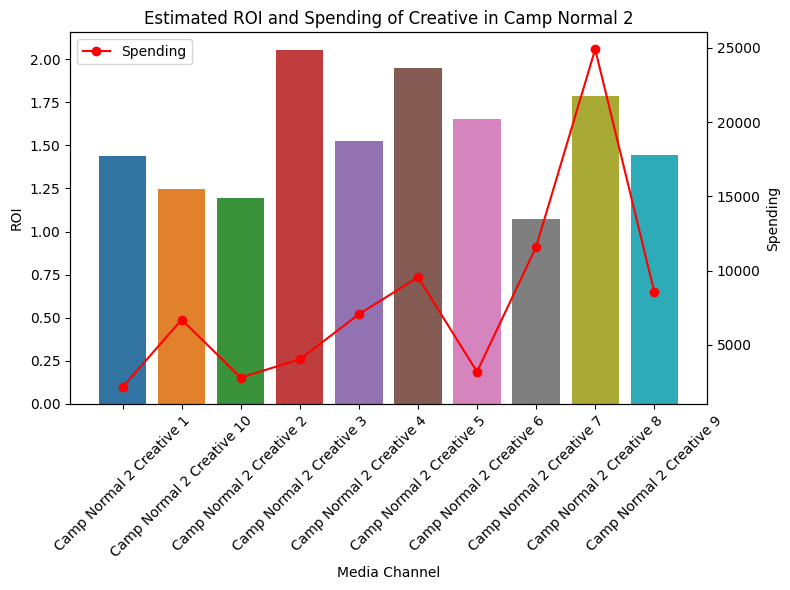

In [41]:
combined_plot(creative_roi.iloc[:,1:], creative_spend.sum(), f'ROI and Spending of Creative in {target_campaign}', creative_names)

# **6.BUDGET OPTIMIZATION**

#### Strategic Allocation for Fixed Budget and Target Scenarios

This final section addresses two fundamental questions in marketing budget allocation:

1. **Fixed Budget Optimization**: How can we distribute a predetermined budget across various media channels to maximize sales?
2. **Fixed Target Optimization**: Given a sales target, what is the most cost-efficient way to allocate our media spend to reach this goal?

Both scenarios are tackled through a constrained optimization approach:

- For the fixed budget scenario, we maintain the overall spend while adjusting individual channel allocations to enhance sales during a specific historical period.
- In the fixed target scenario, we iteratively adjust spend to achieve a desired sales figure in a future period, potentially altering the total budget if necessary.

Through these optimizations, we aim to derive actionable insights that guide how to best distribute a marketing budget under different strategic objectives.

#### Scenario 1: Fixed Budget




1) Past period (in sample) : % of spending change < 20%

In [44]:
# period to change media spend - in this case, 2019
target_period=[_ for _ in date_index if _[:4]=='2018']
# period to observe the sales and sum up
eval_period=date_index[date_index.tolist().index(target_period[0]):date_index.tolist().index(target_period[-1])+14]

starting_values=media_data.loc[target_period].sum()
budget=starting_values.sum()
max_iterations=200;solver_func_tolerance=1e-06;solver_step_size = 1.4901161193847656e-08

In [48]:
def objective_function(media_mix_model, target_scaler, media_scaler, changing_period, media_values):
    # Convert the media values to a NumPy array and reshape
    media_values_array = np.array(media_values).reshape(1, -1)
    scaled_media_values = media_scaler.transform(media_values_array)

    # Create a new DataFrame to modify media spend
    modified_media_data = media_data.copy()
    for period in changing_period:
        modified_media_data.loc[period] = scaled_media_values

    # Predict the KPIs using the modified media data
    predicted_kpis = media_mix_model.predict(
        media=modified_media_data.values,
        extra_features=None,
        target_scaler=target_scaler
    ).mean(axis=0)

    # Calculate the objective value (negative for maximization in 'minimize')
    objective_value = -jnp.sum(predicted_kpis[date_index.tolist().index(changing_period[0]):
                                             date_index.tolist().index(changing_period[-1]) + 1])
    return objective_value

# Now, use the function with the correct reshaping
partial_objective_function = functools.partial(objective_function, mmm, target_scaler2, media_scaler2, eval_period)

# And then call it with starting_values
kpi_without_optim = partial_objective_function(starting_values.to_numpy())

In [46]:
def constraint(media):
  global budget
  return jnp.sum(media)-budget

solution = sp.optimize.minimize(fun=partial_objective_function,x0=starting_values,
    method="SLSQP",
    jac="3-point",
    bounds=sp.optimize.Bounds(lb=starting_values*0.8,ub=starting_values*1.2),
    options={
        "maxiter": max_iterations,
        "disp": True,
        "ftol": solver_func_tolerance,
        "eps": solver_step_size,
    },
    constraints={
        "type": "eq",
        "fun": constraint
    })

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4055669.25
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1


In [49]:
prices = costs / media_data.sum(axis=0)
optimal_budget_allocation = prices * solution.x
previous_budget_allocation = prices * starting_values
kpi_without_optim=partial_objective_function(starting_values)

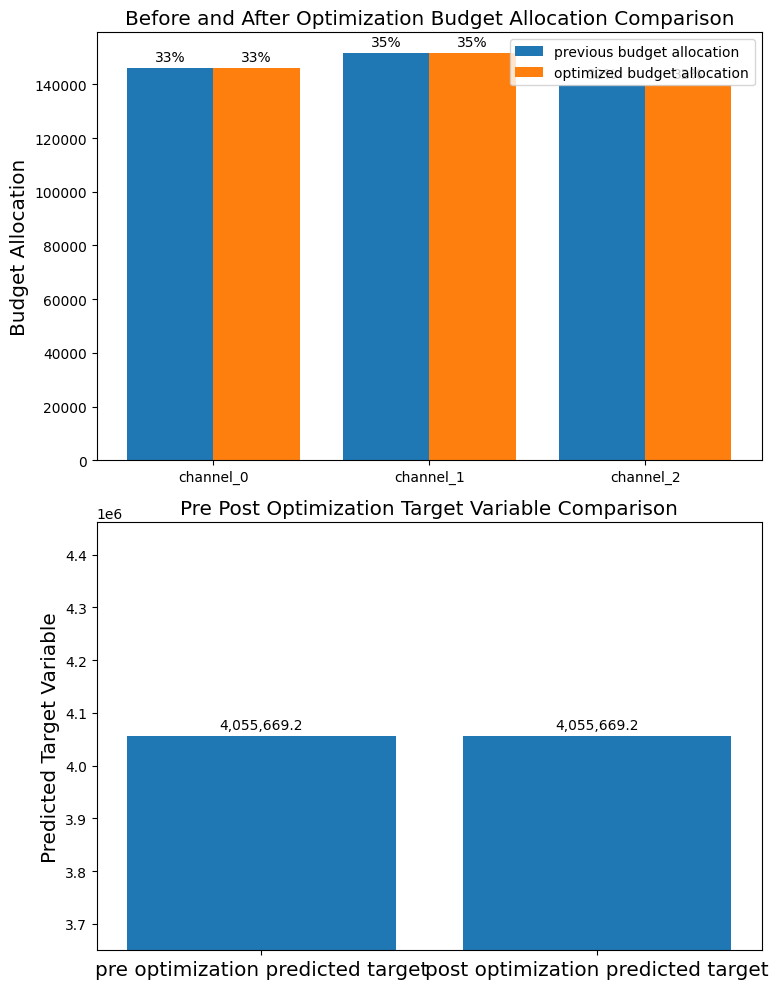

In [50]:
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=np.array(solution['fun']),
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_budget_allocation.values,
                                                previous_budget_allocation=previous_budget_allocation.values,
                                                figure_size=(8,10))

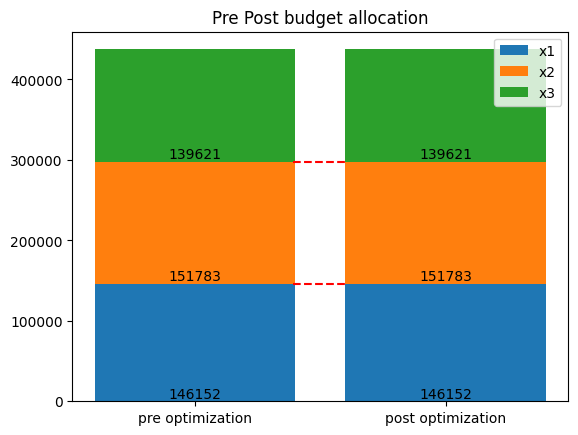

In [51]:
optimize_plot(previous_budget_allocation.values,optimal_budget_allocation.values,media_names)

2) Future period (out of sample)

In [52]:
# total spending
budget = 100000
n_time_periods=10

prices = costs / media_data.sum(axis=0)
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    budget=budget,
    prices=prices.values,
    media_scaler=media_scaler2,
    target_scaler=target_scaler2)
optimal_budget_allocation = prices * solution.x
previous_budget_allocation = prices * previous_media_allocation

Optimization terminated successfully    (Exit mode 0)
            Current function value: -240940.22041688996
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12


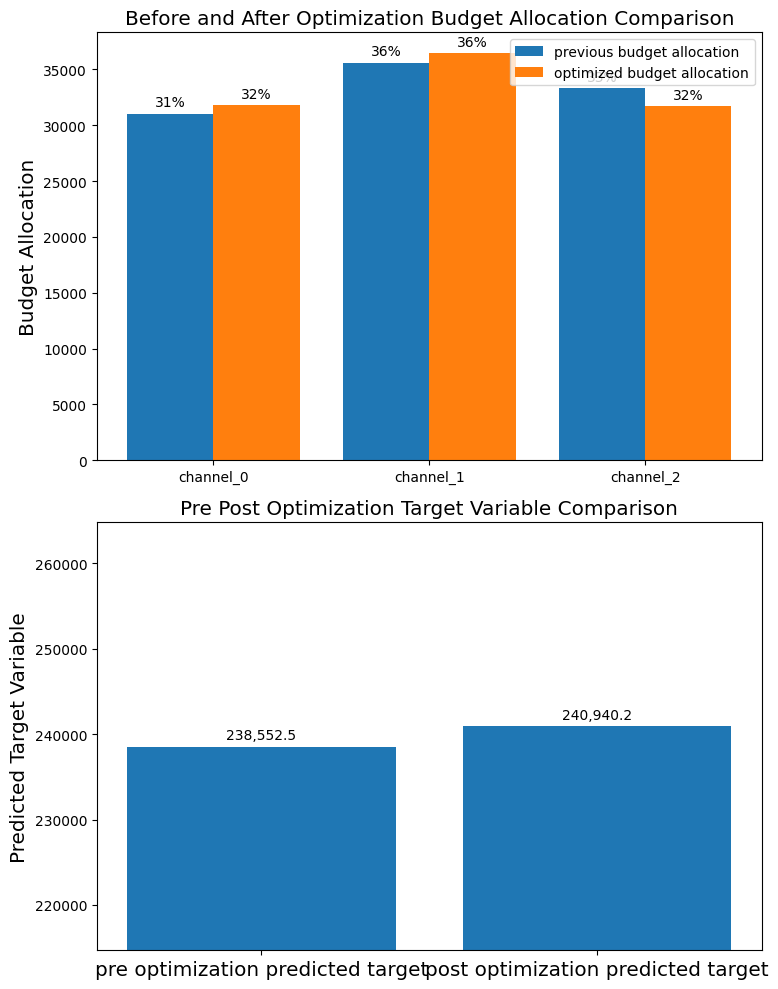

In [53]:
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=np.array(solution['fun']),
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_budget_allocation.values,
                                                previous_budget_allocation=previous_budget_allocation.values,
                                                figure_size=(8,10))

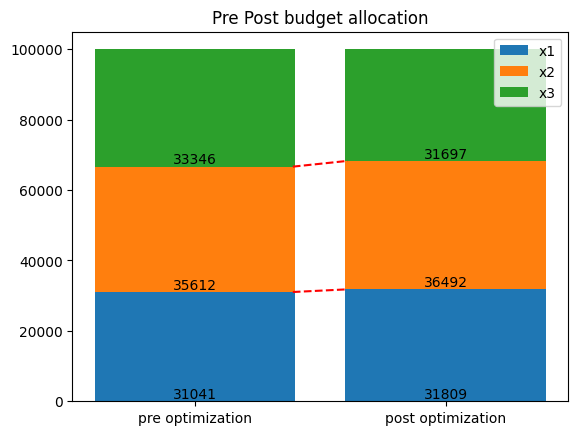

In [54]:
optimize_plot(previous_budget_allocation.values,optimal_budget_allocation.values,media_names)

### Scenario 2: Fixed Target

Past Period (in sample)

In [55]:
# period to change media spend - in this case, 2019
target_period=[_ for _ in date_index if _[:4]=='2019']
# period to observe the sales and sum up
eval_period=date_index[date_index.tolist().index(target_period[0]):date_index.tolist().index(target_period[-1])+14]

starting_values=media_data.loc[target_period].sum()
#target_sales=sum([marketing[marketing['TIMEDESC']==_]['Contribution'].sum() for _ in target_period])
#target_sales=sales.loc[target_period]["Sales"].sum()
max_iterations=200;solver_func_tolerance=1e-06;solver_step_size = 1.4901161193847656e-08

In [57]:
def constraint2(media_mix_model, target, target_scaler, media_scaler, changing_period, media_values):
    # Convert the media values to a NumPy array and reshape
    media_values_array = np.array(media_values).reshape(1, -1)
    scaled_media_values = media_scaler.transform(media_values_array)

    # Create a new DataFrame to modify media spend
    modified_media_data = media_data.copy()
    for period in changing_period:
        modified_media_data.loc[period] = scaled_media_values / len(changing_period)

    # Predict the KPIs using the modified media data
    predicted_kpis = media_mix_model.predict(
        media=modified_media_data.values,
        extra_features=None,
        target_scaler=target_scaler
    ).mean(axis=0)

    # Calculate the constraint value
    constraint_value = target - jnp.sum(predicted_kpis[date_index.tolist().index(changing_period[0]):
                                                       date_index.tolist().index(changing_period[-1]) + 1])
    return constraint_value

# Define the target sales value
target_sales = -constraint2(mmm, 0, target_scaler2, media_scaler2, target_period, starting_values.to_numpy())

# Partially apply the constraint function with constant parameters
partial_constraint2 = functools.partial(constraint2, mmm, target_sales, target_scaler2, media_scaler2, target_period)

In [58]:
def objective_function2(media):
  return jnp.sum(media)

partial_constraint2=functools.partial(constraint2,mmm,target_sales,target_scaler2,media_scaler2,target_period)

solution = sp.optimize.minimize(fun=objective_function2,x0=starting_values,
    method="SLSQP",
    jac="3-point",
    bounds=sp.optimize.Bounds(lb=starting_values*0.8,ub=starting_values*1.2),
    options={
        "maxiter": max_iterations,
        "disp": True,
        "ftol": solver_func_tolerance,
        "eps": solver_step_size,
    },
    constraints={
        "type": "eq",
        "fun": partial_constraint2
    })

Optimization terminated successfully    (Exit mode 0)
            Current function value: 407547.78125
            Iterations: 21
            Function evaluations: 158
            Gradient evaluations: 21


In [59]:
prices = costs / media_data.sum(axis=0)
optimal_budget_allocation = prices * solution.x
previous_budget_allocation = prices * starting_values
kpi_with_optim=objective_function2(solution.x)
kpi_without_optim=objective_function2(starting_values.values)

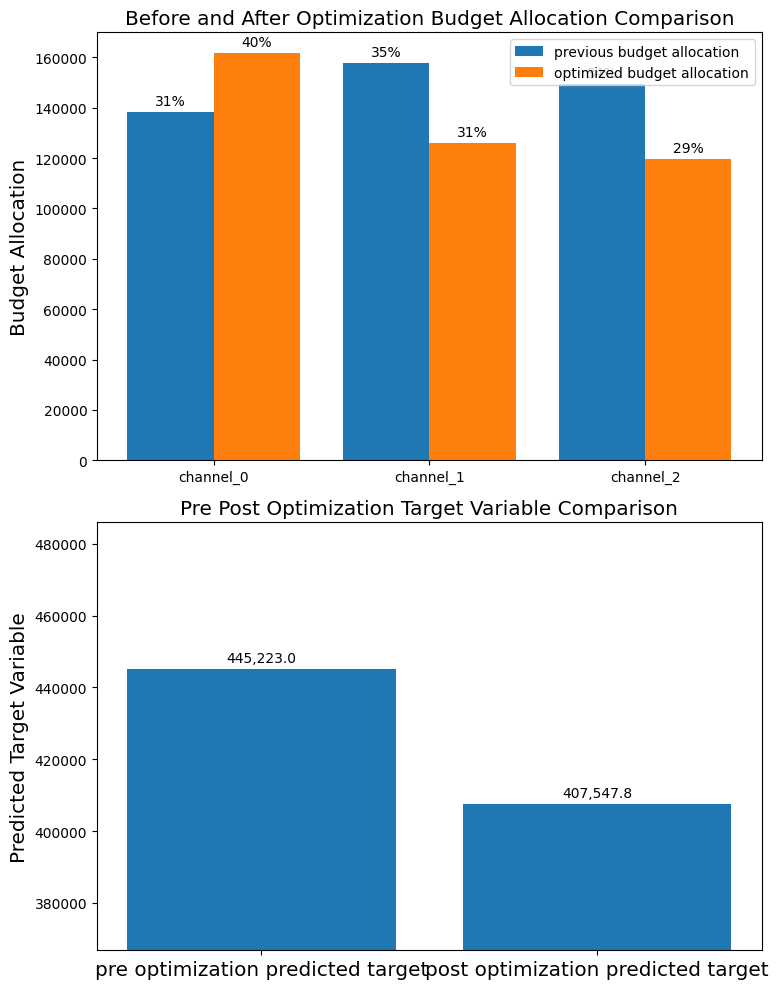

In [60]:
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=-kpi_with_optim,
                                                kpi_without_optim=-kpi_without_optim,
                                                optimal_buget_allocation=optimal_budget_allocation.values,
                                                previous_budget_allocation=previous_budget_allocation.values,
                                                figure_size=(8,10))

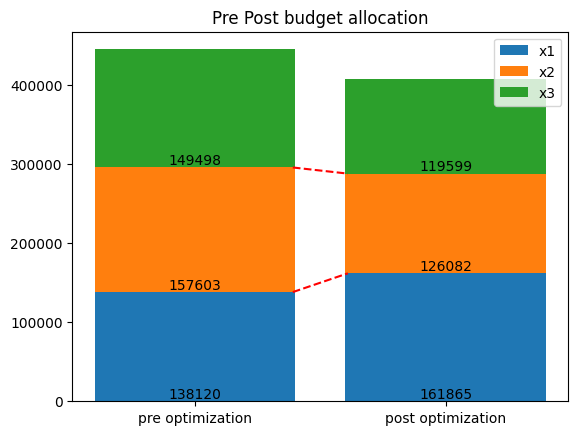

In [61]:
optimize_plot(previous_budget_allocation.values,optimal_budget_allocation.values,media_names)